In [1]:
#Doing this because, sometimes we get an error 'module 'PIL.Image' has no attribute 'register_extensions' in Google Colab
#uninstall the old one
!pip uninstall -y Pillow
# install the new one
!pip install Pillow==4.1.1

Uninstalling Pillow-4.1.1:
  Successfully uninstalled Pillow-4.1.1
  Using cached https://files.pythonhosted.org/packages/36/e5/88b3d60924a3f8476fa74ec086f5fbaba56dd6cee0d82845f883b6b6dd18/Pillow-4.1.1-cp36-cp36m-manylinux1_x86_64.whl


In [0]:
#importing libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from PIL import Image
from skimage import io, transform
import skimage

import cv2 
import torch
from torchvision import transforms, models

In [0]:
vgg = models.vgg19(pretrained=True)

for param in vgg.parameters():
    param.requires_grad_(False)

In [4]:
vgg

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

In [0]:
#downloading the image to work on it. The image is of a dog and class.
!wget -qq https://raw.githubusercontent.com/ramprs/grad-cam/master/images/cat_dog.jpg

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


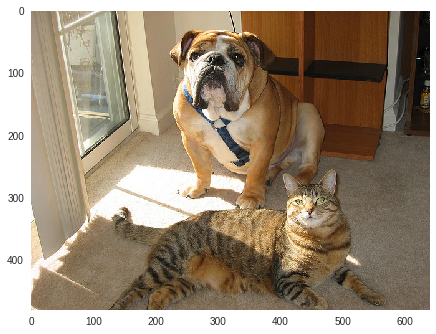

In [6]:
#defining the transformations for the image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

#reading the image
raw_image = io.imread('cat_dog.jpg')
#resizing the image to the shape 224 x 224
image_pil = skimage.transform.resize(raw_image, (224,224))
image_pil = Image.fromarray(np.uint8(image_pil*255))
#the pixels has range from (0 - 1). making them to the range of (0-255) and transforming them to the Image type
image = Image.fromarray(raw_image)

#get the transformed image
transformed_image = transform(image).requires_grad_(True)
#adding the first dimension as batch and converting to cuda
transformed_image = transformed_image.unsqueeze(0).cuda()
#converting the model to cuda
vgg = vgg.cuda()

#displaying the image
plt.grid(False)
plt.imshow(image)

In [7]:
#passing the image from the model
out_vgg = vgg(transformed_image)
#printing the top 5 classes and their scores
out_vgg.topk(5)

(tensor([[13.1441, 13.1323, 12.4624, 11.1150,  9.9907]], device='cuda:0',
        grad_fn=<TopkBackward>),
 tensor([[243, 242, 254, 245, 999]], device='cuda:0'))

In [0]:
#taking the last spatial layer from which we take the feature maps and also take gradients
last_spatial_layer = vgg.features._modules['36']

#defining the function for forward hook, takes the feature map and stores in our_feats
def fwdhook(self, input, output):
  self.our_feats = output

#registering the forward hook
hooked_last_spatial_layer = last_spatial_layer.register_forward_hook(fwdhook)

In [0]:
#defining backward hook, takes the gradients and stores in our_grad_out
def bckdhook(self, grad_in, grad_out):
    self.our_grad_out = grad_out[0]

#registering the backward hook
bckd_hooked_last_spatial_layer = last_spatial_layer.register_backward_hook(bckdhook)

In [10]:
#passing the image from the model
ref_scores = vgg.forward(transformed_image)
#printing the shape of feature maps
print('Shape of output of Max Pool layer:', last_spatial_layer.our_feats.shape)

Shape of output of Max Pool layer: torch.Size([1, 512, 7, 7])


In [11]:
#defining the dog class and cat class and class of interest(which part to highlight on output image)
dog_class = 245
cat_class = 281
class_of_interest = cat_class

#taking the sum of scores of the class_of_interest over all the batches
loss = torch.sum(ref_scores[:, class_of_interest])
loss.backward()

#gradients with respect to the class_of_interest
last_spatial_layer.our_grad_out.shape

torch.Size([1, 512, 7, 7])

In [12]:
#sum of gradients of each layer. so we sum only on 2,3 dimensions. see research paper for more details
alpha_c_k = torch.sum(last_spatial_layer.our_grad_out, [2, 3])
#adding two dimensions at the end to multiply with the feature maps
alpha_c_k = alpha_c_k.unsqueeze(-1).unsqueeze(-1)
print(alpha_c_k.shape)
alpha_into_a = alpha_c_k*last_spatial_layer.our_feats
print(alpha_into_a.shape)

torch.Size([1, 512, 1, 1])
torch.Size([1, 512, 7, 7])


In [13]:
#adding all the feature maps, see research paper for more details
alpha_into_a_channel = torch.sum(alpha_into_a, 1)
print('shape: ', alpha_into_a_channel.shape)
#L_c will containg the pixels that have positive influence on class_of_interest
L_c = torch.nn.functional.relu(alpha_into_a_channel)
print(L_c.shape)

shape:  torch.Size([1, 7, 7])
torch.Size([1, 7, 7])


In [14]:
#converting from tensor to numpy
L_c_numpy = L_c.detach().cpu().numpy()
print(L_c_numpy.shape)
L_c_numpy = L_c_numpy[0]
print(L_c_numpy.shape)

#dividing by max element because, we want the image with range of[0,1]
L_c_numpy_norm = L_c_numpy/L_c_numpy.max()

(1, 7, 7)
(7, 7)


In [15]:
from skimage import transform
L_c_numpy_norm_resized = transform.resize(L_c_numpy_norm, (224,224))

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


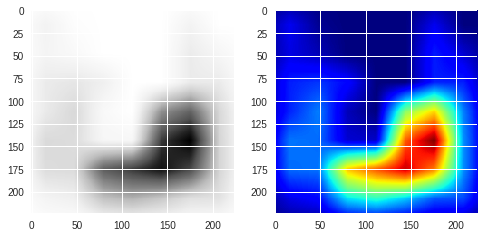

In [16]:
#plotting the images
fig, ax = plt.subplots(1,2)
ax[0].imshow(L_c_numpy_norm_resized)
ax[1].imshow(L_c_numpy_norm_resized, cmap='jet')

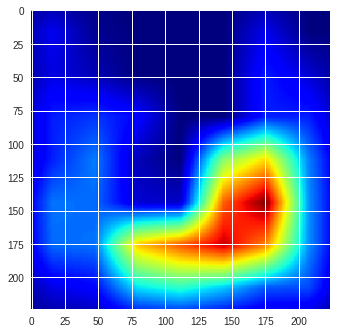

In [17]:
#convering into heat map. It also gives last alpha layer, so just taking till 3
heat_map = cm.jet(L_c_numpy_norm_resized)[:,:,:3]
#converting the heat map to pil Image to blend
heat_map_pil = Image.fromarray(np.uint8(heat_map*255))
plt.imshow(heat_map)

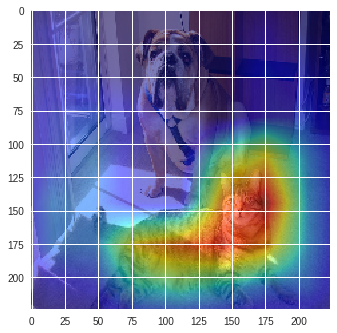

In [18]:
#blending the heat map with the original image
after_blend = Image.blend(image_pil, heat_map_pil, alpha=0.5)
plt.imshow(after_blend)